In [2]:
import sys

In [3]:
import os
print(os.getcwd())

/Users/qiwei/Desktop/Desktop - Qiwei’s MacBook Pro M1/Job/RacketGo/tennis-analysis-test-1


In [4]:
# 获取项目根目录的路径
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# 将项目根目录添加到 sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

In [5]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from utils.video_utils import read_video, save_video
from trackers import PlayerTracker, BallTracker
import constants
from utils import bbox_utils, compute_player_stats_utils, conversions, player_stats_drawer_utils, video_utils

In [6]:
input_video_path = "input/tennis_match_video1.mp4"
video_frames, fps = read_video(input_video_path)

视频原始帧率: 60.0 FPS
读取完成，总帧数: 3556


In [7]:
# Detect Players and Ball
print("2. 初始化球员跟踪器...")
player_tracker = PlayerTracker(model_path="models/yolov8x.pt")
print("3. 初始化球跟踪器...")
ball_tracker = BallTracker(model_path='models/yolo9_best_1.pt')

2. 初始化球员跟踪器...
3. 初始化球跟踪器...


In [8]:
print("4. 开始检测球员...")
player_detections = player_tracker.detect_frames(video_frames, 
                                                read_from_stub=True, 
                                                stub_path="tracker_stubs/player_detections.pkl")
print(f"球员检测完成，检测到{len(player_detections)}帧的球员")


print("5. 开始检测球...")
ball_detections = ball_tracker.detect_frames(video_frames, 
                                            read_from_stub=True, 
                                            stub_path="tracker_stubs/ball_detections.pkl")
print(f"球检测完成，检测到{len(ball_detections)}帧的球")

print("6. 开始插值球的位置...")
ball_detections = ball_tracker.interpolate_ball_positions(ball_detections)
print("球位置插值完成")


4. 开始检测球员...
球员检测完成，检测到3556帧的球员
5. 开始检测球...
球检测完成，检测到3556帧的球
6. 开始插值球的位置...
球位置插值完成


In [ ]:
# 打印每帧中检测到的球员 ID
print("检测到的球员 ID:")
for frame_idx, player_dict in enumerate(player_detections):
    player_ids = list(player_dict.keys())
    print(f"Frame {frame_idx}: Detected player IDs: {player_ids}")

In [10]:
from court_line_detector import CourtLineDetector
from mini_court import MiniCourt
from utils.compute_player_stats_utils import compute_player_stats



In [11]:
# Court Line Detector model
print("7. 初始化球场检测器...")
court_model_path = "models/keypoints_model.pth"
court_line_detector = CourtLineDetector(court_model_path)
print("8. 开始检测球场关键点...")
court_keypoints = court_line_detector.predict(video_frames[0])
print(f"球场关键点检测完成，检测到{len(court_keypoints)}个关键点")

7. 初始化球场检测器...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


8. 开始检测球场关键点...
球场关键点检测完成，检测到28个关键点


In [14]:
player_detections_filtered = player_tracker.choose_and_filter_players(court_keypoints, player_detections)
print(f"球员选择和过滤完成，剩余{len(player_detections)}帧的球员数据")

球员选择和过滤完成，剩余3556帧的球员数据


In [ ]:
# 打印每帧中检测到的球员 ID
print("检测到的球员 ID:")
for frame_idx, player_dict in enumerate(player_detections_filtered):
    player_ids = list(player_dict.keys())
    print(f"Frame {frame_idx}: Detected player IDs: {player_ids}")

In [11]:
# Save video
output_video_path = "output_videos/output_video.avi"
print("13. 开始保存视频...")
save_video(output_video_frames, output_video_path)

13. 开始保存视频...
使用原始视频帧率: 60.0 FPS
视频保存完成，总帧数: 678，帧率: 60.0 FPS


In [12]:


shot_cut_output = "output_videos/shotcut/shot1.avi"
video_cutter = VideoCut(output_video_path, shot_cut_output, ball_shot_frames)
video_cutter.cut_video()
print("14. 所有处理完成！")

Video Duration: 11.3s, FPS: 60, Total Frames: 678
14. 所有处理完成！


In [8]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from utils.audio_utils import AudioProcessor

def analyze_hit_sounds_from_video(video_path, ball_shot_frames, fps=60):
    """
    分析击球声音的频率特征，并绘制频谱图。
    :param video_path: 视频文件路径。
    :param ball_shot_frames: 检测到的击球帧索引列表。
    :param fps: 视频帧率。
    """
    # 初始化音频处理器
    audio_processor = AudioProcessor(sr=22050)
    
    # 从视频中提取音频信号
    y, sr = audio_processor.extract_audio_signal(video_path)

    # 将击球帧转换为时间点（秒）
    hit_times = [frame / fps for frame in ball_shot_frames]

    # 计算短时傅里叶变换 (STFT)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # 绘制频谱图
    plt.figure(figsize=(14, 6))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram (Log Scale)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

    # 标记击球声音的时间点
    for hit_time in hit_times:
        plt.axvline(x=hit_time, color='r', linestyle='--', label='Hit Sound' if hit_time == hit_times[0] else "")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 分析击球声音的频率范围
    for hit_time in hit_times:
        start_sample = int(hit_time * sr)
        end_sample = start_sample + int(0.1 * sr)  # 分析击球声音的前 0.1 秒
        hit_segment = y[start_sample:end_sample]

        # 计算击球声音的频谱
        hit_spectrum = np.abs(librosa.stft(hit_segment))
        hit_frequencies = librosa.fft_frequencies(sr=sr)

        # 找到频率范围
        max_amplitude = np.max(hit_spectrum, axis=1)
        dominant_frequencies = hit_frequencies[np.where(max_amplitude > np.percentile(max_amplitude, 90))]
        print(f"击球时间 {hit_time:.2f}s 的主要频率范围: {dominant_frequencies.min():.2f} Hz - {dominant_frequencies.max():.2f} Hz")

In [10]:
from trackers import PlayerTracker, BallTracker
from utils import (read_video, 
                   save_video,
                   draw_player_stats,
                   compute_player_stats
                   )

# Read Video
print("1. 开始读取视频...")
input_video_path = "input/tennis_match_video1.mp4"
video_frames, fps = read_video(input_video_path)
print(f"视频读取完成，共{len(video_frames)}帧")

# Detect Players and Ball
print("2. 初始化球员跟踪器...")
player_tracker = PlayerTracker(model_path="models/yolov8x.pt")
print("3. 初始化球跟踪器...")
ball_tracker = BallTracker(model_path='models/yolo9_best_1.pt')

print("5. 开始检测球...")
ball_detections = ball_tracker.detect_frames(video_frames, 
                                            read_from_stub=True, 
                                            stub_path="tracker_stubs/ball_detections.pkl")
print(f"球检测完成，检测到{len(ball_detections)}帧的球")

print("11. 开始检测击球帧...")
ball_shot_frames = ball_tracker.get_ball_shot_frames(ball_detections)
print(f"击球帧检测完成: {ball_shot_frames}")

1. 开始读取视频...
视频原始帧率: 60.0 FPS
读取完成，总帧数: 3556
视频读取完成，共3556帧
2. 初始化球员跟踪器...
3. 初始化球跟踪器...
5. 开始检测球...
球检测完成，检测到3556帧的球
11. 开始检测击球帧...
击球帧检测完成: [34, 1400, 1416, 1445, 1597, 1600, 1989, 2427, 3291, 3302, 3417, 3465, 3473, 3479, 3486]


/Users/qiwei/Desktop/Desktop - Qiwei’s MacBook Pro M1/Job/RacketGo/tennis-analysis-test-1/trackers/ball_tracker.py:81: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
/Users/qiwei/Desktop/Desktop - Qiw

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'qt', 'minor_version': '0', 'compatible_brands': 'qt', 'creation_time': '2025-04-16T10:54:18.000000Z'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1920, 1080], 'bitrate': 14972, 'fps': 60.0, 'codec_name': 'hevc', 'profile': '(Main)', 'metadata': {'Metadata': '', 'creation_time': '2025-04-16T10:54:18.000000Z', 'handler_name': 'Core Media Video', 'vendor_id': '[0][0][0][0]', 'encoder': 'HEVC'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 126, 'metadata': {'Metadata': '', 'creation_time': '2025-04-16T10:54:18.000000Z', 'handler_name': 'Core Media Audio', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 59.27, 'bitrate': 15107, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'hevc', 'v

/var/folders/96/_n1lf8k53dxg2d2mxxmwwjl80000gn/T/ipykernel_1567/2815844388.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/qiwei/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


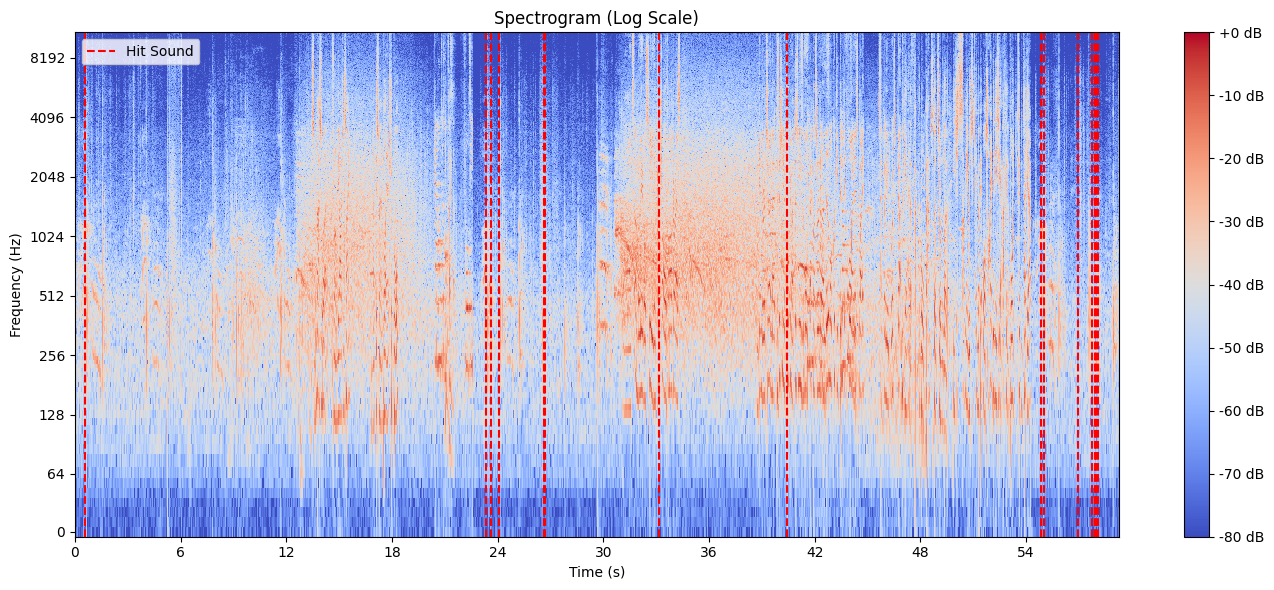

击球时间 0.57s 的主要频率范围: 129.20 Hz - 3380.71 Hz
击球时间 23.33s 的主要频率范围: 86.13 Hz - 1270.46 Hz
击球时间 23.60s 的主要频率范围: 118.43 Hz - 1722.66 Hz
击球时间 24.08s 的主要频率范围: 161.50 Hz - 2777.78 Hz
击球时间 26.62s 的主要频率范围: 118.43 Hz - 2476.32 Hz
击球时间 26.67s 的主要频率范围: 86.13 Hz - 2207.15 Hz
击球时间 33.15s 的主要频率范围: 139.97 Hz - 3100.78 Hz
击球时间 40.45s 的主要频率范围: 107.67 Hz - 2993.12 Hz
击球时间 54.85s 的主要频率范围: 86.13 Hz - 3456.08 Hz
击球时间 55.03s 的主要频率范围: 150.73 Hz - 1668.82 Hz
击球时间 56.95s 的主要频率范围: 107.67 Hz - 4694.24 Hz
击球时间 57.75s 的主要频率范围: 64.60 Hz - 1227.39 Hz
击球时间 57.88s 的主要频率范围: 53.83 Hz - 1798.02 Hz
击球时间 57.98s 的主要频率范围: 0.00 Hz - 1733.42 Hz
击球时间 58.10s 的主要频率范围: 75.37 Hz - 1658.06 Hz


In [9]:
# 分析击球声音
analyze_hit_sounds_from_video(input_video_path, ball_shot_frames, fps=60)

In [10]:
print(ball_shot_frames)

[34, 1400, 1416, 1445, 1597, 1600, 1989, 2427, 3291, 3302, 3417, 3465, 3473, 3479, 3486]


In [11]:
from video_cut.video_cut import VideoCut

refined_hit_points = [33, 88, 240, 322, 461, 540, 695, 900, 959, 1011, 1129, 1150, 1400, 1448, 1510, 1600, 1700, 1780, 3295, 3350, 3459, 3538]
print("Refined hit points (frames):", refined_hit_points)

# 初始化 VideoCut 实例（这里传入必要的参数，具体参数请根据你的实际情况补充）
video_cutter = VideoCut(
    ball_detections=ball_detections,  # 这里需要传入实际的ball_detections
    ball_shot_frames=ball_shot_frames, # 这里需要传入实际的ball_shot_frames
    acceleration_threshold=50.0,
    frame_merge_threshold=10
)

# 调用实例方法生成rallies
rallies = video_cutter.generate_rallies(refined_hit_points, max_frame_gap=240, buffer_frames=120)
print("Generated rallies:", rallies)

Refined hit points (frames): [33, 88, 240, 322, 461, 540, 695, 900, 959, 1011, 1129, 1150, 1400, 1448, 1510, 1600, 1700, 1780, 3295, 3350, 3459, 3538]
Generated rallies: [{'start_frame': 0, 'end_frame': 1900, 'hit_points': [33, 88, 240, 322, 461, 540, 695, 900, 959, 1011, 1129, 1150, 1400, 1448, 1510, 1600, 1700, 1780]}, {'start_frame': 3175, 'end_frame': 3658, 'hit_points': [3295, 3350, 3459, 3538]}]


In [ ]:
rallies = [{'start_frame': 0, 'end_frame': 800, 'hit_points': [33, 88, 240, 322, 461, 540, 695]}, 
{'start_frame': 868, 'end_frame': 1243, 'hit_points': [900, 959, 1011, 1129, 1150]},
{'start_frame': 1388, 'end_frame': 1858, 'hit_points': [1400, 1448, 1510, 1600, 1700, 1780]}, 
{'start_frame': 3275, 'end_frame': 3555, 'hit_points': [3295, 3350, 3459, 3538]}]
